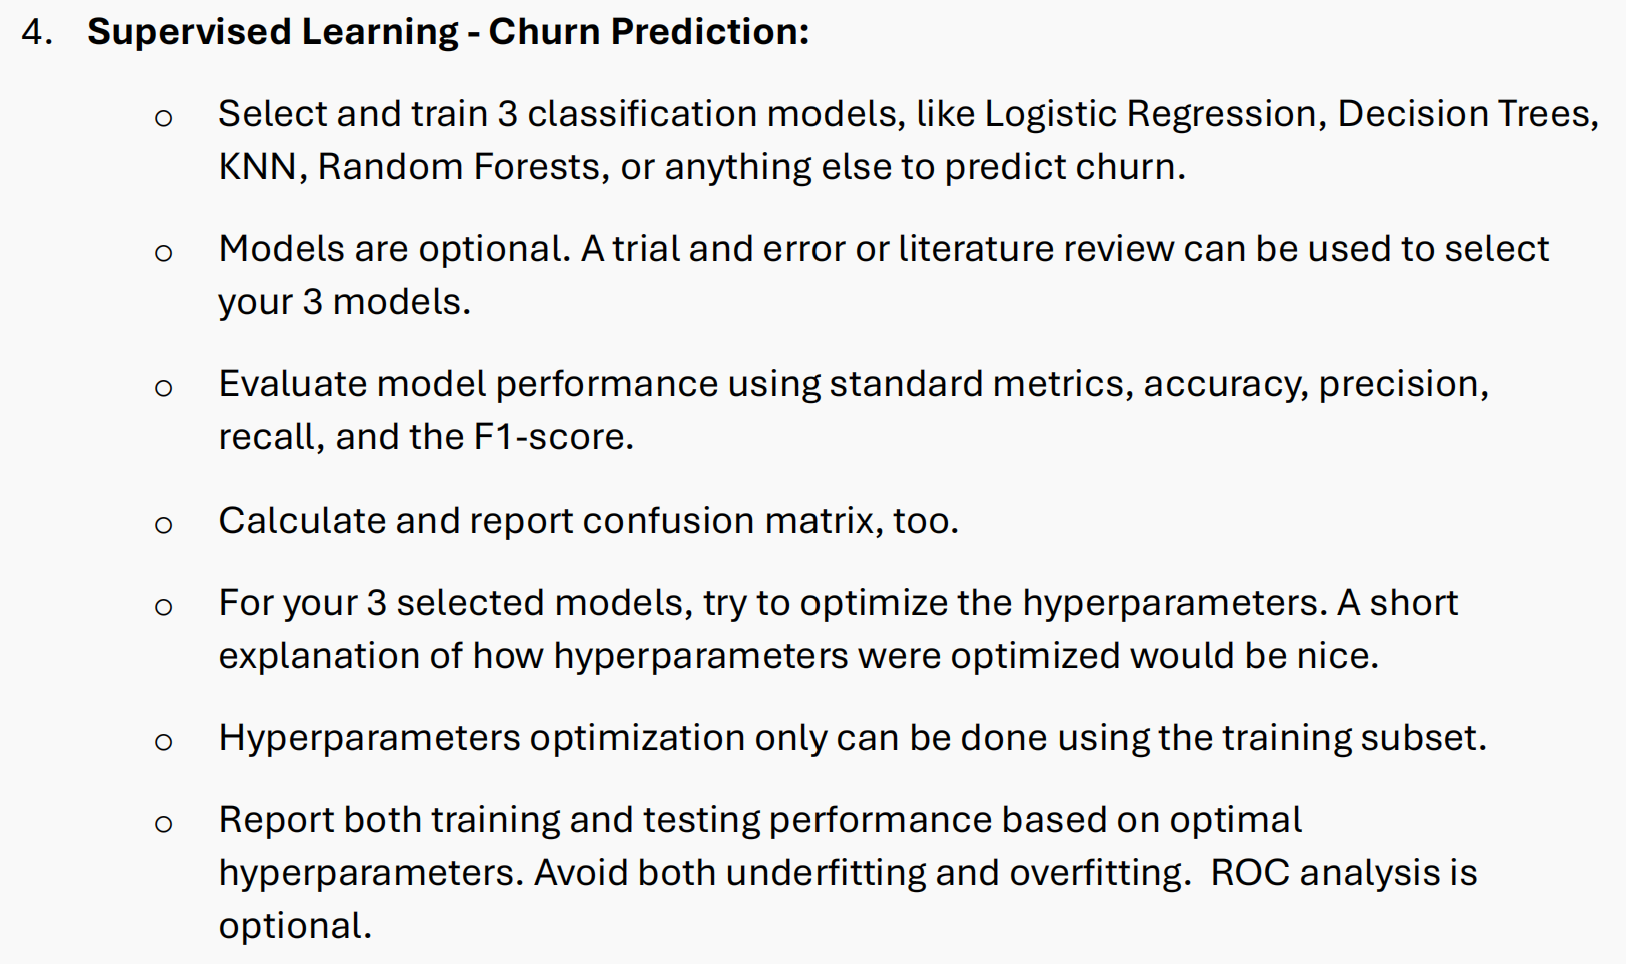

In [35]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

## 1. Data Setup

- Loading data
- Separating `X_train` and `X_test`, `Y_train` and `Y_test`

In [1]:
train_dir = "./data/train_preprocessed.csv"
test_dir = "./data/test_preprocessed.csv"

In [6]:
train_df = pd.read_csv(train_dir, index_col=0)
test_df = pd.read_csv(test_dir, index_col=0)

In [7]:
train_df.head(5)

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,...,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area code_408,Area code_415,Area code_510
0,0.524793,0.0,1.0,0.50,0.755701,0.68750,0.755701,0.542755,0.582353,0.542866,...,False,False,False,False,False,False,False,False,True,False
1,0.438017,0.0,1.0,0.52,0.460661,0.76875,0.460597,0.537531,0.605882,0.537690,...,False,False,False,False,False,False,False,False,True,False
2,0.561983,0.0,0.0,0.00,0.693843,0.71250,0.693830,0.333242,0.647059,0.333225,...,False,False,False,False,False,False,False,False,True,False
3,0.342975,1.0,0.0,0.00,0.853478,0.44375,0.853454,0.170195,0.517647,0.170171,...,False,False,False,False,False,False,False,True,False,False
4,0.305785,1.0,0.0,0.00,0.475200,0.70625,0.475184,0.407754,0.717647,0.407959,...,False,False,False,False,False,False,False,False,True,False


In [30]:
Y_column = "Churn"
X_columns = [col for col in train_df.columns if col != "Churn"]

X_train, y_train, X_test, y_test = (
    train_df[X_columns],
    train_df[Y_column],
    test_df[X_columns],
    test_df[Y_column],
)

## 2. Model Training & Tuning
- Apply 5-fold stratified CV with Grid Search

In [32]:
RANDOM_STATE = 110

# models selected
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(random_state=RANDOM_STATE),
}

# Grid search setup
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

hyperparameters = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
}

In [33]:
def train_eval_model(model, X_train, X_test, y_train, y_test):
    """
    Trains model on train set, reports result on both train and test set
    """
    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    metrics = {
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Train Precision": precision_score(y_train, y_train_pred),
        "Test Precision": precision_score(y_test, y_test_pred),
        "Train Recall": recall_score(y_train, y_train_pred),
        "Test Recall": recall_score(y_test, y_test_pred),
        "Train F1": f1_score(y_train, y_train_pred),
        "Test F1": f1_score(y_test, y_test_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_test_pred),
    }
    return metrics


# # Evaluate all models
# results = {}
# for name, model in models.items():
#     results[name] = train_eval_model(model, X_train, X_test, y_train, y_test)

In [36]:
tuned_models = {}

# tuning entry point
for model_name in tqdm.tqdm(models):
    model = models[model_name]
    param_grid = hyperparameters[model_name]

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv_strategy,
        scoring="f1",
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)

    tuned_models[model_name] = grid_search.best_estimator_

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:05<00:00, 21.72s/it]


In [37]:
# # Evaluate all models
results = {}
for name, model in tuned_models.items():
    results[name] = train_eval_model(model, X_train, X_test, y_train, y_test)

In [38]:
def display_metrics(model_name, result_dict):
    print(f"\n{model_name} Performance:")
    print(f"Train Accuracy: {result_dict['Train Accuracy']:.4f}")
    print(f"Test Accuracy: {result_dict['Test Accuracy']:.4f}")
    print(f"Train Precision: {result_dict['Train Precision']:.4f}")
    print(f"Test Precision: {result_dict['Test Precision']:.4f}")
    print(f"Train Recall: {result_dict['Train Recall']:.4f}")
    print(f"Test Recall: {result_dict['Test Recall']:.4f}")
    print(f"Train F1: {result_dict['Train F1']:.4f}")
    print(f"Test F1: {result_dict['Test F1']:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(result_dict["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Logistic Regression Performance:
Train Accuracy: 0.8698
Test Accuracy: 0.8636
Train Precision: 0.6158
Test Precision: 0.5357
Train Recall: 0.2809
Test Recall: 0.3158
Train F1: 0.3858
Test F1: 0.3974


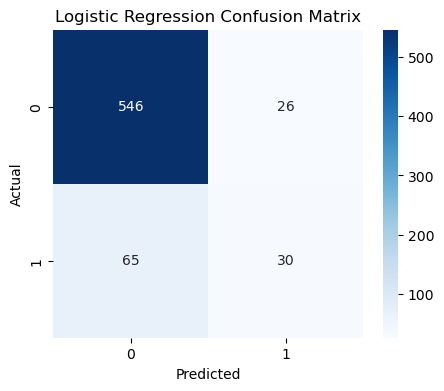


Random Forest Performance:
Train Accuracy: 1.0000
Test Accuracy: 0.9325
Train Precision: 1.0000
Test Precision: 0.8788
Train Recall: 1.0000
Test Recall: 0.6105
Train F1: 1.0000
Test F1: 0.7205


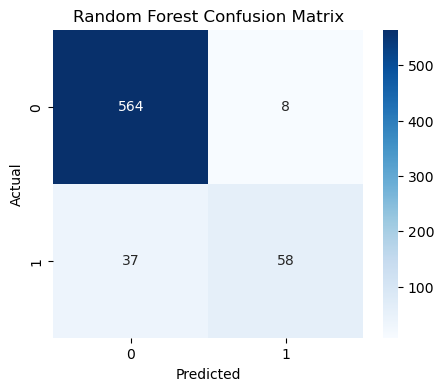


XGBoost Performance:
Train Accuracy: 0.9966
Test Accuracy: 0.9535
Train Precision: 1.0000
Test Precision: 0.8478
Train Recall: 0.9768
Test Recall: 0.8211
Train F1: 0.9883
Test F1: 0.8342


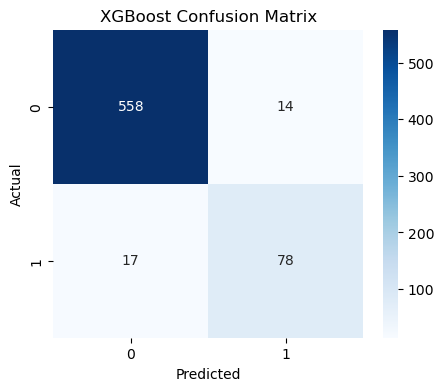

In [39]:
for name, result_dict in results.items():
    display_metrics(name, result_dict)